In [1]:
import pandas as pd

### References

There are many pandas tutorials out there, so I will not attempt to recreate one of them. Instead, I will show a practical example relating to quantum chemistry calculations of the hydrogen molecule ($H_2$). Hopefully this example will inspire you to start using pandas in your own research.

[tutorials][tutorials]

cheat sheet [1][1], [2][2]

[1]:https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
[2]:https://www.datacamp.com/community/blog/python-pandas-cheat-sheet#gs.UNw2qDY
[tutorials]:http://pandas.pydata.org/pandas-docs/stable/tutorials.html

## 1. Creating a DataFrame

### Construct from dictionary

To collect simulation data scattered across many folders, I build a list of dictionaries. One dictionary for a run.

In [2]:
import sys
sys.path.insert(0,'scripts')
from parse_gms import parse_gms_inp,parse_gms_out

In the data/h2_cis folder, I ran GAMESS to get the ground and first excited state energies of the H2 molecule at a number of bond lenths. I put a script in the scripts folder to parse GAMESS input and output. (do NOT open the script file, you will be horrified)

In [3]:
# take input file and turn into dictionary
parse_gms_inp('data/h2_cis/sep1.40/sep1.40-cis.inp')

{'cityp': 'cis',
 'coord': 'unique',
 'dist': 1.4,
 'gbasis': 'cct',
 'guess': 'huckel',
 'icharg': '0',
 'ispher': '1',
 'mult': '1',
 'nstate': '5',
 'runtyp': 'energy',
 'scftyp': 'rhf',
 'units': 'bohr'}

In [4]:
# take output file and turn into dictionary
parse_gms_out('data/h2_cis/sep1.40/sep1.40-cis.out')

{'E0': -1.1329605255, 'E1': -0.6313262084}

Construct a list of dictionaries by looping through the runs and parse every input-output pair.

In [5]:
import os
import subprocess as sp

def collect(database,rundir):
    if not os.path.isfile(database):
        # find all input files
        all_inps = sp.check_output(['find',rundir,'-ipath','*.inp']).split('\n')[:-1]

        data = []
        for gms_inp in all_inps:

            settings = parse_gms_inp(gms_inp) # get inputs
            gms_out  = gms_inp.replace('inp','out') # assume output name
            outputs  = parse_gms_out(gms_out) # get outputs

            # glue input,output together
            entry = outputs
            entry.update({'settings':settings})
            # simply entry.update(settings), if you want all settings to be exposed

            # I also store run path, because folder name is sometimes useful
            path   = os.path.dirname(gms_inp) 
            entry.update({'path':path}) 

            data.append(entry)
        # end for
        df = pd.DataFrame(data)
        df.to_json(database) # I always save data to file to avoid rerunning analysis

    else:
        df = pd.read_json(database)
    # end if
    return df
# end def collect

database = 'data/h2_cct.json'
rundir   = 'data/h2_cis/'
df0 = collect(database,rundir)

In [6]:
df0.head()

,E0,E1,path,settings
0,-1.091084,-0.687865,data/h2_cis/sep2.00,"{u'scftyp': u'rhf', u'guess': u'huckel', u'nst..."
1,-1.017630,-0.696946,data/h2_cis/sep2.70,"{u'scftyp': u'rhf', u'guess': u'huckel', u'nst..."
10,-1.110410,-0.677497,data/h2_cis/sep1.80,"{u'scftyp': u'rhf', u'guess': u'huckel', u'nst..."
11,-1.109381,-0.546966,data/h2_cis/sep1.10,"{u'scftyp': u'rhf', u'guess': u'huckel', u'nst..."
12,-1.042448,-0.434778,data/h2_cis/sep0.90,"{u'scftyp': u'rhf', u'guess': u'huckel', u'nst..."


In [7]:
df0['settings'].apply(pd.Series).head()

,cityp,coord,dist,gbasis,guess,icharg,ispher,mult,nstate,runtyp,scftyp,units
0,cis,unique,2.0,cct,huckel,0,1,1,5,energy,rhf,bohr
1,cis,unique,2.7,cct,huckel,0,1,1,5,energy,rhf,bohr
10,cis,unique,1.8,cct,huckel,0,1,1,5,energy,rhf,bohr
11,cis,unique,1.1,cct,huckel,0,1,1,5,energy,rhf,bohr
12,cis,unique,0.9,cct,huckel,0,1,1,5,energy,rhf,bohr


In [8]:
# if you want all settings to be exposed
flat_df = pd.concat( [df0['settings'].apply(pd.Series),df0],axis=1 
         ).drop('settings',axis=1)
flat_df.head()

,cityp,coord,dist,gbasis,guess,icharg,ispher,mult,nstate,runtyp,scftyp,units,E0,E1,path
0,cis,unique,2.0,cct,huckel,0,1,1,5,energy,rhf,bohr,-1.091084,-0.687865,data/h2_cis/sep2.00
1,cis,unique,2.7,cct,huckel,0,1,1,5,energy,rhf,bohr,-1.017630,-0.696946,data/h2_cis/sep2.70
10,cis,unique,1.8,cct,huckel,0,1,1,5,energy,rhf,bohr,-1.110410,-0.677497,data/h2_cis/sep1.80
11,cis,unique,1.1,cct,huckel,0,1,1,5,energy,rhf,bohr,-1.109381,-0.546966,data/h2_cis/sep1.10
12,cis,unique,0.9,cct,huckel,0,1,1,5,energy,rhf,bohr,-1.042448,-0.434778,data/h2_cis/sep0.90


## 2. Selecting data from DataFrame

first let me show you the energy surfaces of $H_2$

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# select columns, and sort by bond length
mydf = flat_df[['dist','E0','E1']].sort_values('dist')
mydf.head()

,dist,E0,E1
14,0.8,-0.978110,-0.346066
12,0.9,-1.042448,-0.434778
19,1.0,-1.083744,-0.499201
11,1.1,-1.109381,-0.546966
17,1.2,-1.124154,-0.582934


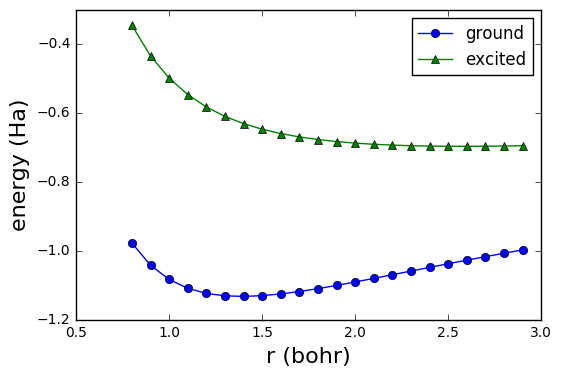

In [10]:
# Fig. 1: visualize data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('r (bohr)',fontsize=16)
ax.set_ylabel('energy (Ha)',fontsize=16)

ax.plot(mydf['dist'],mydf['E0'],'o-',label='ground')
ax.plot(mydf['dist'],mydf['E1'],'^-',label='excited')
ax.legend()

Rows can be selected by index,

In [11]:
mydf.loc[[21,10]] # select rows with index 21 and 10

,dist,E0,E1
21,2.4,-1.048757,-0.696558
10,1.8,-1.110410,-0.677497


or by position.

In [12]:
mydf.iloc[0:2] # select first two rows in mydf

,dist,E0,E1
14,0.8,-0.978110,-0.346066
12,0.9,-1.042448,-0.434778


The most useful selection method is probably by boolean array.

In [13]:
sel = mydf['dist']<1.0 # all points with bond length < 1 bohr
mydf.loc[sel]

,dist,E0,E1
14,0.8,-0.978110,-0.346066
12,0.9,-1.042448,-0.434778


Column selection can be done at the same time.

In [14]:
mydf.loc[sel,['E0','E1']]

,E0,E1
14,-0.978110,-0.346066
12,-1.042448,-0.434778


# OMG my advisor wants me to change a parameter!

I did a lousy job with the second batch of runs. There are missing data, is that a problem?

In [15]:
# first load new data, add to current DataFrame
database = 'data/h2_ccd.json'
rundir   = 'data/ccd_cis/'
df1 = collect(database,rundir)

df_combined = pd.concat([df0,df1]).reset_index(drop=True)
# unwrap settings
df = pd.concat( [df_combined['settings'].apply(pd.Series),df_combined],axis=1 
         ).drop('settings',axis=1)

In [16]:
# I changed the quantum chemistry basis set
df['gbasis'].unique()

array([u'cct', 'ccd'], dtype=object)

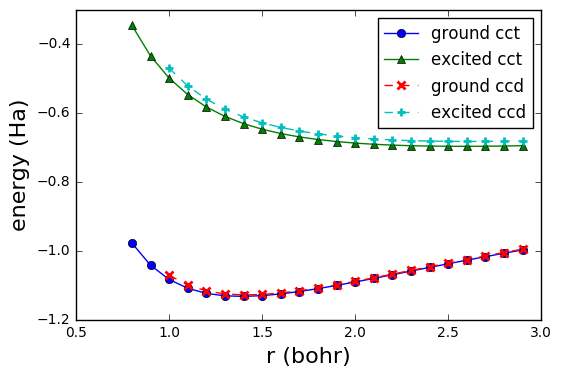

In [17]:
# Fig. 2: visualize new data
ccd_df = df.loc[df['gbasis']=='ccd'
    ,['dist','E0','E1']].sort_values('dist')
cct_df = df.loc[df['gbasis']=='cct'
    ,['dist','E0','E1']].sort_values('dist')

fig,ax = plt.subplots(1,1)
ax.set_xlabel('r (bohr)',fontsize=16)
ax.set_ylabel('energy (Ha)',fontsize=16)

ax.plot(cct_df['dist'],cct_df['E0'],'o-',label='ground cct')
ax.plot(cct_df['dist'],cct_df['E1'],'^-',label='excited cct')

ax.plot(ccd_df['dist'],ccd_df['E0'],'x--',label='ground ccd',mew=2)
ax.plot(ccd_df['dist'],ccd_df['E1'],'+--',label='excited ccd',mew=2)
ax.legend()

we see that the answers are not sensitive to basis set, phew...

now we quantify the effect of the parameter change

In [18]:
# list out the energies as a function of data and parameter
compare = df.pivot('dist','gbasis','E0')
compare.head()
# we see two missing data for gbasis=ccd

gbasis,ccd,cct
dist,,
0.8,NaN,-0.978110
0.9,NaN,-1.042448
1.0,-1.071355,-1.083744
1.1,-1.100029,-1.109381
1.2,-1.117042,-1.124154


You can drop missing data with df.dropna(), but many functions still work even with missing data

In [19]:
import numpy as np
# pandas can't care less if data is missing or not
print compare.mean()
# however, in this case, we need to drop the missing data for a fair comparison
print compare.dropna().mean()

gbasis
ccd   -1.076890
cct   -1.074011
dtype: float64
gbasis
ccd   -1.074808
cct   -1.078363
dtype: float64


Only after dropping the nan do we see that the cct basis set gives lower energy, as is evident from the plot. Lesson: check your nans!

In [20]:
compare.isnull().any()

gbasis
ccd    True
cct    True
dtype: bool

## 3. Column operations

In [21]:
# aggregate is also helpful for high level view of data
df.groupby('gbasis')['E0'].agg([np.mean,np.std,len])

,mean,std,len
gbasis,,,
ccd,-1.076890,0.043606,20.0
cct,-1.074011,0.048177,22.0


In [22]:
# different sets of functions can be applied to different columns!
df.groupby('gbasis')['E0','E1'].agg({'E0':[np.mean,np.std,len],'E1':np.mean})

E1        E0                
            mean      mean       std   len
gbasis                                    
ccd    -0.640396 -1.076890  0.043606  20.0
cct    -0.633541 -1.074011  0.048177  22.0

### simple column algebra like excel

some chemists do not like atomic units, so I have to convert bohr to angstrom and hatree to ev *face palm*. This is where aggregate comes in handy

In [23]:
df['dist_ang'] = df['dist']*0.529
df['E0_ev'] = df['E0'] * 27

## 4. Row comparisons

Suppose I want to plot the difference between the curves between ccd and cct in Fig. 2. We will have to select out the appropriate entries and subtract. Pandas can handle this elegantly

In [24]:
# energy gained by switching from ccd to cct
diff = ccd_df.set_index('dist') - cct_df.set_index('dist')

In [25]:
diff.head() # notice the nans are automatically taken care of

,E0,E1
dist,,
0.8,NaN,NaN
0.9,NaN,NaN
1.0,0.012388,0.028617
1.1,0.009352,0.025209
1.2,0.007113,0.022738


In [26]:
# you can access 'dist' with diff.index, but I like 'diff' to be a col.
diff.reset_index(inplace=True)

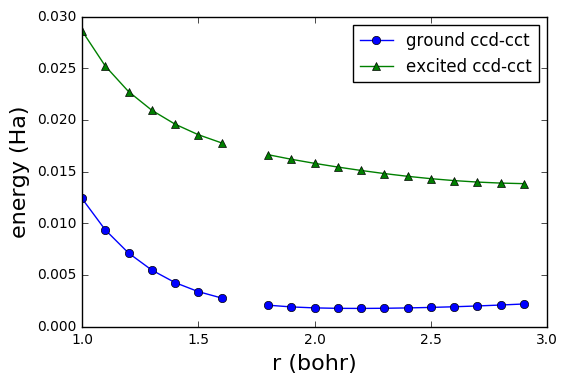

In [27]:
# Fig. 2: visualize new data
fig,ax = plt.subplots(1,1)
ax.set_xlabel('r (bohr)',fontsize=16)
ax.set_ylabel('energy (Ha)',fontsize=16)

ax.plot(diff['dist'],diff['E0'],'o-',label='ground ccd-cct')
ax.plot(diff['dist'],diff['E1'],'^-',label='excited ccd-cct')

ax.legend()

The bond distance is of type float. Sometimes the above procedure will fail when the decimals do not exactly match. In that case, you make a unique index column

In [28]:
df['dist_str'] = df['dist'].apply(lambda x:str(round(x,2)))

## 5. exploring someone else's DataFrame

### Convert from csv
If data is already in a tabulated form, then pd.read_X() will read convert data from file type X to a pandas DataFrame. I usually check out the size of the table with **df.info()**. info() prints the number of rows (26729) and all column labels. **df.head()** will show the first few entries.

In [29]:
df_animals = pd.read_csv('data/train.csv')
df_animals.info()

df_animals.columns;df_animals.index; # these can be directly modified (quick&dirty)
#df_animals.rename(columns={'Name':'my name'},inplace=True) # cleaner rename

df_animals.head()

#pd.read_ # uncomment and double tap to see all the file types that can be read
#df_animals.to_ # double tap to see all file types can be saved to

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
